In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd
from neuralprophet import NeuralProphet
import plotly.graph_objects as go
import pickle

In [39]:
df = pd.read_csv('./dataset/sensors_202205211506.csv', parse_dates=['created_at'], index_col='created_at')


cols = ['temperature']
df = df[cols].astype(float)


In [40]:
freq = '1min'

In [41]:
df = df.resample(freq).mean().interpolate()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4386 entries, 2022-05-18 14:01:00 to 2022-05-21 15:06:00
Freq: T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  4386 non-null   float64
dtypes: float64(1)
memory usage: 68.5 KB


In [43]:
df = df.reset_index()

In [44]:
new_column = df[['created_at', 'temperature']] 
new_column.dropna(inplace=True)
new_column.columns = ['ds', 'y'] 

In [86]:
n = NeuralProphet(
    changepoints_range=0.95,
    n_changepoints=120,
    batch_size=32,
    learning_rate=0.2,
    weekly_seasonality=False,
    daily_seasonality=15,
)
model = n.fit(new_column, freq=freq)


INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 127
Epoch[127/127]: 100%|██████████| 127/127 [00:47<00:00,  2.67it/s, SmoothL1Loss=0.000256, MAE=0.14, RMSE=0.207, RegLoss=0] 


In [87]:
future = n.make_future_dataframe(new_column, periods=60*24,n_historic_predictions=True)
forecast = n.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min
INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min
INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min


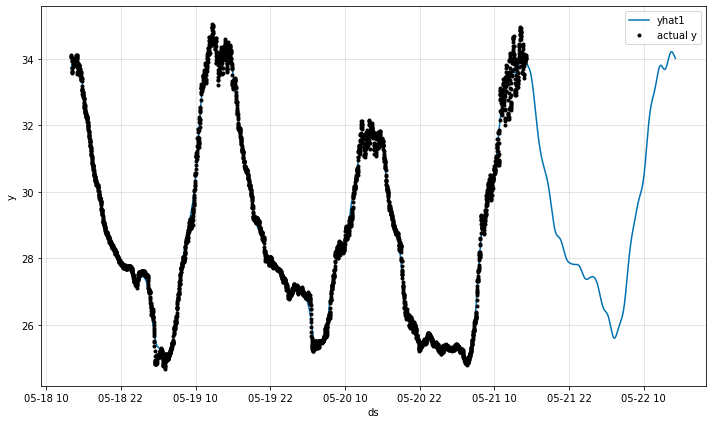

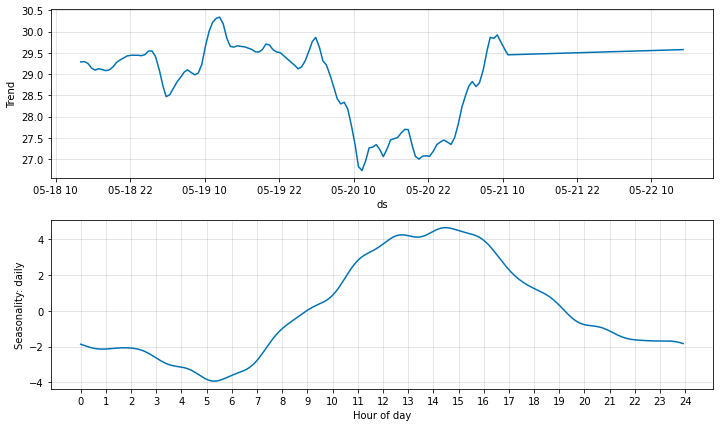

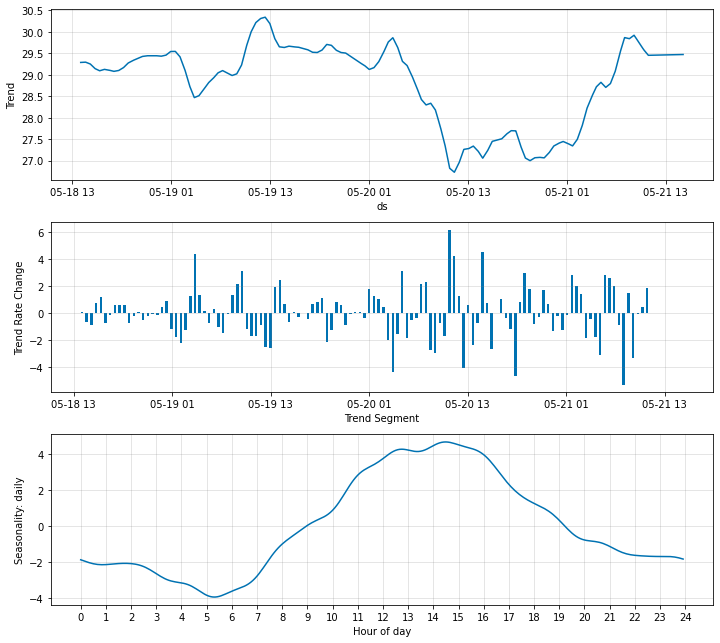

In [88]:
fig_forecast = n.plot(forecast)
fig_components = n.plot_components(forecast)
fig_model = n.plot_parameters()

In [89]:
trace1 = go.Scatter(
    x = new_column['ds'].values,
    y = new_column['y'].values,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast['ds'].values,
    y = forecast['yhat1'].values,
    mode = 'lines',
    name = 'Prediction'
)

layout = go.Layout(
    title = "temp",
    xaxis = {'title' : "datetime"},
    yaxis = {'title' : "temperature"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [90]:
with open('./models/neuralprophet_model.pkl', "wb") as f:
    pickle.dump(n, f)